In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import scanpy.api as sc
import math
import random
from scipy import stats
from timeit import timeit
from itertools import combinations

sns.set(style='whitegrid', palette='Set2', font_scale=1.3)

In [3]:
# load data and cell type annotations
rawdata = sc.read('/Users/sbell/git/tabula-muris/00_data_ingest/00_facs_raw_data/FACS/Heart-counts.csv').transpose() 
cell_annotation = pd.read_csv('/Users/sbell/git/tabula-muris/00_data_ingest/03_tissue_annotation_csv/Heart_facs_annotation.csv', index_col=0) 
rawdata.obs['cell_type'] = cell_annotation.cell_ontology_class

In [7]:
# do a cursory normalization of the data
adata = rawdata.copy()
sc.pp.filter_cells(adata, min_genes=100) # make the matrix less sparse
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) # each cell sums to 1

filter_result = sc.pp.filter_genes_dispersion(adata.X, n_top_genes=10000, log=False)
adata._inplace_subset_var(filter_result.gene_subset)  # filter genes
sc.pp.log1p(adata) # log scale
sc.pp.scale(adata, max_value=10) # center + scale

(5966, 10000)


In [17]:
def time_per_dataset(fn, dataset_scales, title=None):
    time = { size: timeit(lambda : fn(dataset), number=1) for size, dataset in dataset_scales.items() }
    fig, ax = plt.subplots()
    x,y=list(zip(*time.items()))
    sns.regplot(pd.Series(x),pd.Series(y))
    ax.set_xlabel('Number of cells')
    ax.set_ylabel('Execution time (seconds)')
    if title:
        ax.set_title(title)
    ax.set_xlim(0, max(dataset_scales.keys()))
    plt.tight_layout()
    plt.show()

In [9]:
## Run PCA and ask for the first 2 PCs
sc.tl.pca(adata, n_comps=2) 

## We'll run clustering once initially so we can use cluster-informed downsampling later
sc.pp.neighbors(adata,metric='euclidean', random_state=2018) 
sc.tl.louvain(adata, random_state=2018) # Then use the Louvain algorithm to identify clusters
adata.obs['louvain'] = adata.obs['louvain'].astype(str)

def downsample_by_cluster(adata, N, cluster_key = 'louvain'):
    '''Cluster-informed downsampling of cells in an anndata object
       adata: anndata object
       proportion: proportion of cells from each cluster to KEEP
       cluster_key: where to find cluster IDs in adata.obs[]
       returns adata[subsample,:]
    '''
    assert 1 < N < len(adata.obs_names)
    assert cluster_key in adata.obs.columns.values, 'Oops. Run clustering first with sc.pp.neighbors -> sc.tl.louvain'

    total_N = len(adata.obs_names)
    clusters = adata.obs.groupby('louvain')
    all_selected = []

    for cluster, cells in clusters.groups.items():
        cluster_size = len(cells)
        choose_k = int(N*(cluster_size/total_N))
        selected = random.sample(list(cells), k=choose_k)
        all_selected += selected

    return adata[all_selected, :]

### Downsample to 30%, 50%, 70%, and 100% of original data size.
total_N = len(adata.obs)
dataset_scales = { int(p*total_N) : downsample_by_cluster(adata, p) for p in [50, 500, 5000] }

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11.2 µs


## Scanpy clustering & parameters  
### Scanpy includes only one method for clustering, `sc.tl.louvain`, which implements the louvain algorithm to assign cells to clusters based on the k-nearest-neighbors graph first built with `sc.pp.neighbors`.  
  
#### `sc.pp.neighbors` parameters to expose to user:  
* n_neighbors: int  
* method: str {'umap', 'gauss'}  

[?] metric: str {any metric accepted by scipy.spatial.distance.pdist}*
* Currently the non-`euclidean` metric options are broken (issue submitted). I'd just stick with fixing `euclidean` behind the scenes for now, and we can revisit this option later.  
  
#### `sc.tl.louvain` parameters to expose to user:  
* resolution: float  

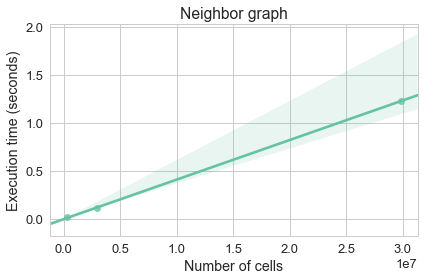

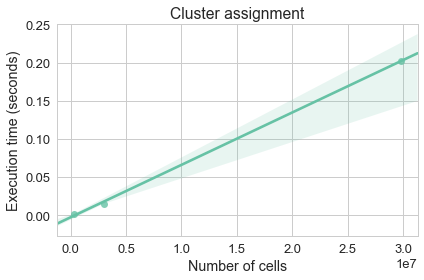

In [12]:
time_per_dataset(sc.pp.neighbors, dataset_scales, title='Neighbor graph')
time_per_dataset(sc.tl.louvain, dataset_scales, title='Cluster assignment')

## Dimensionality reduction ("layout")  
### Scanpy provides several options for embeddings, most notably the four listed below.  
  
### `sc.tl.draw_graph()` params to expose:  
* layout: str {‘fa’,‘grid_fr’,‘lgl’,‘drl’}  
_`layout` accepts any igraph layout value; I've noted the subset of these that are appropriate and fast according to the scanpy docs._  
_Notably, draw_graph relies on the precomputation of `neighbors` (just like cluster assignment). Perhaps it makes sense to just compute `adata.pp.neighbors()` once on launch? I need to look into whether this needs to be recomputed every time the data is regraphed/subsetted in order to be valid for downstream methods._    
    
### `sc.tl.tsne()` params to expose:  
* perplexity: float
* learning_rate: float
* early_exaggeration: float

### `sc.tl.umap()` params to expose:  
* min_dist (float)
* spread (float)
* alpha (float)
* gamma (float) 

### `sc.pp.pca()` params to expose: 
* PCA: None

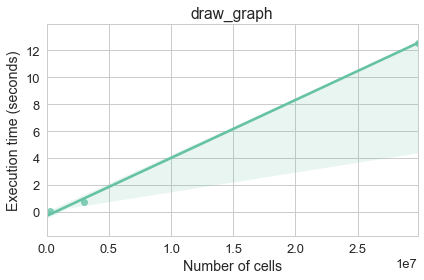

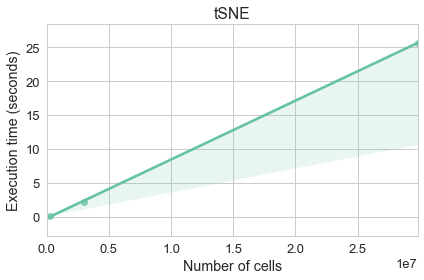

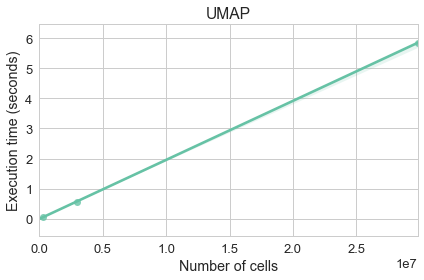

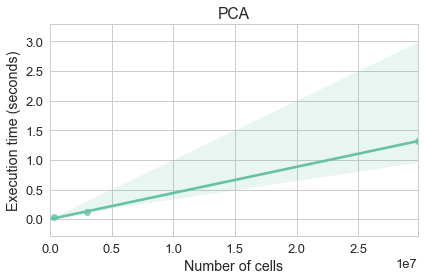

In [18]:
### Important note: these times are all with PCs & neighbor graph precomputed!

time_per_dataset(sc.tl.draw_graph, dataset_scales, title='draw_graph')
time_per_dataset(sc.tl.tsne, dataset_scales, title='tSNE')
time_per_dataset(sc.tl.umap, dataset_scales, title='UMAP')
time_per_dataset(sc.tl.pca, dataset_scales, title='PCA')